# Cargar datos de entrenamiento

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt


#Convertir a linea central desde un solo plano focal
#bright_path = '/kaggle/input/sperm3d-centerlinefromfocalplane/bright_field'
#hue_path    = '/kaggle/input/sperm3d-centerlinefromfocalplane/height_map'

#Convertir a aplanado
#bright_path = '/kaggle/input/sperm3d-centerlinefromfocalplane/bright_field'
#hue_path    = '/kaggle/input/sperm3d-centerlinefromfocalplane/height_map'

bright_path  = '/kaggle/input/sperm-z-color-plane-20/DL-Color/bright_field'
#hue_path  = '/kaggle/input/sperm-z-color-plane-20/DL-Color/bright_field'
value_path  = '/kaggle/input/sperm-z-color-plane-20/DL-Color/value'


image_name = sorted(os.listdir(bright_path))

# Splitting the data into train and test sets
train_test_split = 1024+256  # Adjust this as needed
train_name_1 = image_name[:train_test_split]

train_valid_split = 1024
train_name= train_name_1[:train_valid_split]
valid_name = train_name_1[train_valid_split:]

# Construir generadores para el entrenamiento

In [2]:
from skimage import io

def data_generator(filenames, batch_size):
    num_samples = len(filenames)
    while True:
        # Shuffle the indices at the start of each epoch
        indices = np.random.permutation(num_samples)
        
        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i:i+batch_size]
            #batch_file_pairs = [file_pairs[j] for j in batch_indices]
            batch_inputs = [io.imread(os.path.join(bright_path,filenames[j])) for j in batch_indices]
            batch_outputs= [io.imread(os.path.join(value_path,   filenames[j])) for j in batch_indices]
            #
            #yield np.array(batch_inputs)/255, np.ceil(np.array(batch_outputs)/255)
            #yield np.array(batch_inputs)/255, np.array(batch_outputs)
            
            #identidad
            yield np.array(batch_outputs), np.array(batch_outputs)


batch_size = 32
train_generator = data_generator(train_name, batch_size)
validation_generator = data_generator(valid_name, batch_size)

(2, 32, 480, 640)


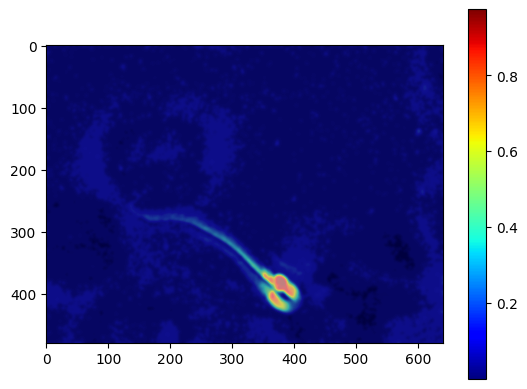

In [3]:
for tr in train_generator:
    print(np.array(tr).shape)
    break
plt.imshow(tr[0][0],cmap="gray")
c=plt.imshow(tr[1][0],cmap="jet",alpha=np.where(tr[1][0]==0,0.0,0.5))
plt.colorbar(c)
plt.show()

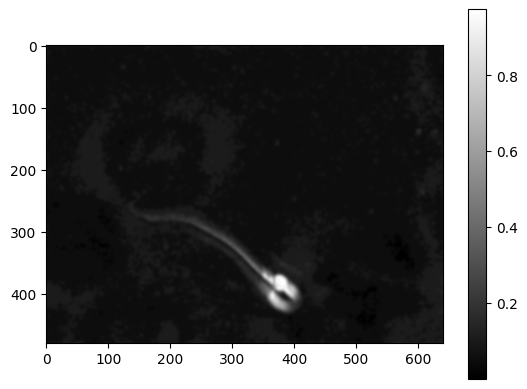

In [4]:
plt.imshow(tr[0][0],cmap="gray")
plt.colorbar()
plt.show()

In [5]:
print(np.max(tr[1][0]))

0.9740605069174748


# Construir unet

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from skimage.metrics import structural_similarity as ssim


def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    #x = layers.Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding="same", kernel_initializer="he_normal")(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)
    x = layers.Conv2D(n_filters, 3, padding="same", kernel_initializer="he_normal")(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)
    x = layers.Conv2D(n_filters, 3, padding="same", kernel_initializer="he_normal")(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)
    
    
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 2, strides=2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    return x

def build_unet_model():
    # inputs
    inputs = layers.Input(shape=(480, 640, 1))

    # encoder: contracting path - downsample
    # 1 - downsample
    n_filters_first = 6
    f1, p1 = downsample_block(inputs, n_filters_first*2)
    # 2 - downsample
    f2, p2 = downsample_block(p1, n_filters_first * 2)
    # 3 - downsample
    f3, p3 = downsample_block(p2, n_filters_first * 4)
    # 3 - downsample
    #f4, p4 = downsample_block(p3, n_filters_first * 8)


    # 5 - bottleneck
    bottleneck = double_conv_block(p3, n_filters_first * 8)

    # decoder: expanding path - upsample
    #u6 = upsample_block(bottleneck, f4, n_filters_first * 8)
    
    # 7 - upsample
    u7 = upsample_block(bottleneck, f3, n_filters_first * 4)
    # 8 - upsample
    u8 = upsample_block(u7, f2, n_filters_first * 2)
    # 9 - upsample
    u9 = upsample_block(u8, f1, n_filters_first)

    # outputs
    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(u9)

    # U-Net model with TensorFlow's Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

unet_model = build_unet_model()

def weighted_bce(ground_truth,y_pred):
    ground_truth = tf.cast(ground_truth,float)
    weights =  ground_truth * 75 + 1.
    bce = K.binary_crossentropy(ground_truth, y_pred)
    weighted_bce = K.mean(bce * weights)
    return weighted_bce

checkpoint_filepath = 'unet2-5.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='loss',  # Change to 'val_loss' to monitor weighted BCE loss
    mode='min',  # Change to 'min' since we are monitoring loss
    save_best_only=True
)



m = tf.keras.metrics.MeanIoU(num_classes=2)

def dice_loss_2D(y_true, y_pred, smooth=1e-7):
    # Ensure both y_true and y_pred are float32
    y_true = tf.cast(y_true, tf.float32)
    #print("Cantidad de ceros en y_true:", tf.reduce_sum(tf.cast(y_true == 0, tf.int32)))

    y_pred = tf.cast(y_pred, tf.float32)

    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    
    dice_loss = 1.0 - dice
    return dice_loss


def dice_2D(y_true, y_pred, smooth=1e-7):
    # Ensure both y_true and y_pred are float32
    y_true = tf.cast(tf.where(y_true==0,0,1), tf.float32)
    y_pred = tf.cast(tf.where(y_pred==0,0,1), tf.float32)
    
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice


def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

# Add the Dice coefficient metric to your model compilation
unet_model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="mae")#tf.keras.losses.BinaryCrossentropy(),
              #metrics=[SSIMLoss])

unet_model.summary()



Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 480, 640, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 480, 640, 12)   │            120 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_21            │ (None, 480, 640, 12)   │              0 │ conv2d_22[0][0]        │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 480, 640, 12)   │          1,308 │ leaky_re_lu_21[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_22            │ (None, 480, 640, 12)   │              0 │ conv2d_23[0][0]        │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 480, 640, 12)   │          1,308 │ leaky_re_lu_22[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_23            │ (None, 480, 640, 12)   │              0 │ conv2d_24[0][0]        │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 240, 320, 12)   │              0 │ leaky_re_lu_23[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 240, 320, 12)   │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 240, 320, 12)   │          1,308 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_24            │ (None, 240, 320, 12)   │              0 │ conv2d_25[0][0]        │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 240, 320, 12)   │          1,308 │ leaky_re_lu_24[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_25            │ (None, 240, 320, 12)   │              0 │ conv2d_26[0][0]        │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 240, 320, 12)   │          1,308 │ leaky_re_lu_25[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_26            │ (None, 240, 320, 12)   │              0 │ conv2d_27[0][0]        │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4      

 Total params: 105,439 (411.87 KB)

 Trainable params: 105,439 (411.87 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
print("Pesos:")
for layer in unet_model.layers:
    if 'conv' in layer.name:
        weights = layer.get_weights()
        print(f"{layer.name}: {np.mean(weights[0])}, {np.std(weights[0])}")

Pesos:
conv2d_22: 0.008969046175479889, 0.463549941778183
conv2d_23: -0.0032237761188298464, 0.13476774096488953
conv2d_24: 0.002538110828027129, 0.13586150109767914
conv2d_25: -0.004875137936323881, 0.13819196820259094
conv2d_26: 0.008384965360164642, 0.13838180899620056
conv2d_27: 0.0021446349564939737, 0.1355004757642746
conv2d_28: 0.003226607572287321, 0.13576743006706238
conv2d_29: -1.7389056665706448e-06, 0.09548231214284897
conv2d_30: 8.392729796469212e-05, 0.09662430733442307
conv2d_31: 0.0006270277663134038, 0.09574035555124283
conv2d_32: 0.00031757380929775536, 0.06800360977649689
conv2d_33: 0.0001392731792293489, 0.06805481016635895
conv2d_transpose_3: 0.000351925496943295, 0.08382762223482132
conv2d_34: -0.0004734966205433011, 0.0681246891617775
conv2d_35: 0.0009887474589049816, 0.09586058557033539
conv2d_36: 0.0016104221576824784, 0.09559602290391922
conv2d_transpose_4: 0.0001712464145384729, 0.11563156545162201
conv2d_37: -9.586606756784022e-05, 0.09567664563655853
conv2d

In [18]:
# Start the timer
import time
import tensorflow.keras.backend as K

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau


# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='loss',  # Monitor validation loss
    patience=20,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights of the best-performing model
)


# Define the ReduceLROnPlateau callback
reduce_lr_callback = ReduceLROnPlateau(
    monitor='loss',
    factor=0.1,  # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=5,  # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1  # Print a message when the learning rate is reduced
)

start_time = time.time()

# Train the model
unet_model.fit(
    train_generator,
    steps_per_epoch=int(np.floor(len(train_name) / batch_size)),
    epochs=5,
    validation_data=validation_generator,
    validation_steps=int(np.floor(len(valid_name) / batch_size)),
    callbacks=[model_checkpoint_callback,early_stopping_callback]#,reduce_lr_callback]
)

# Calculate the training time
training_time = time.time() - start_time

# Print the training time
print("Training time:", training_time/60, "min")

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 558ms/step - loss: 0.2402 - val_loss: 0.0941
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 493ms/step - loss: 0.0804 - val_loss: 0.0935
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 488ms/step - loss: 0.0797 - val_loss: 0.0951
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 473ms/step - loss: 0.0803 - val_loss: 0.0942
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 474ms/step - loss: 0.0806 - val_loss: 0.0939
Training time: 1.6025217572848003 min


Pesos:


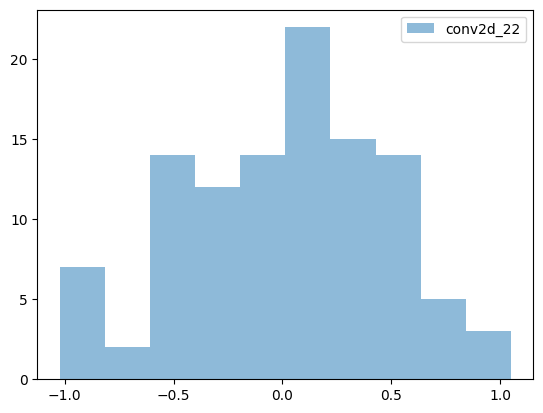

In [19]:
print("Pesos:")
for layer in unet_model.layers:
    if 'conv' in layer.name:
        weights = layer.get_weights()
        plt.hist(np.array(weights[0]).flatten(),label=layer.name,alpha=.5)
        break
        #print(f"{layer.name}: {np.mean(weights[0])}, {np.std(weights[0])}")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


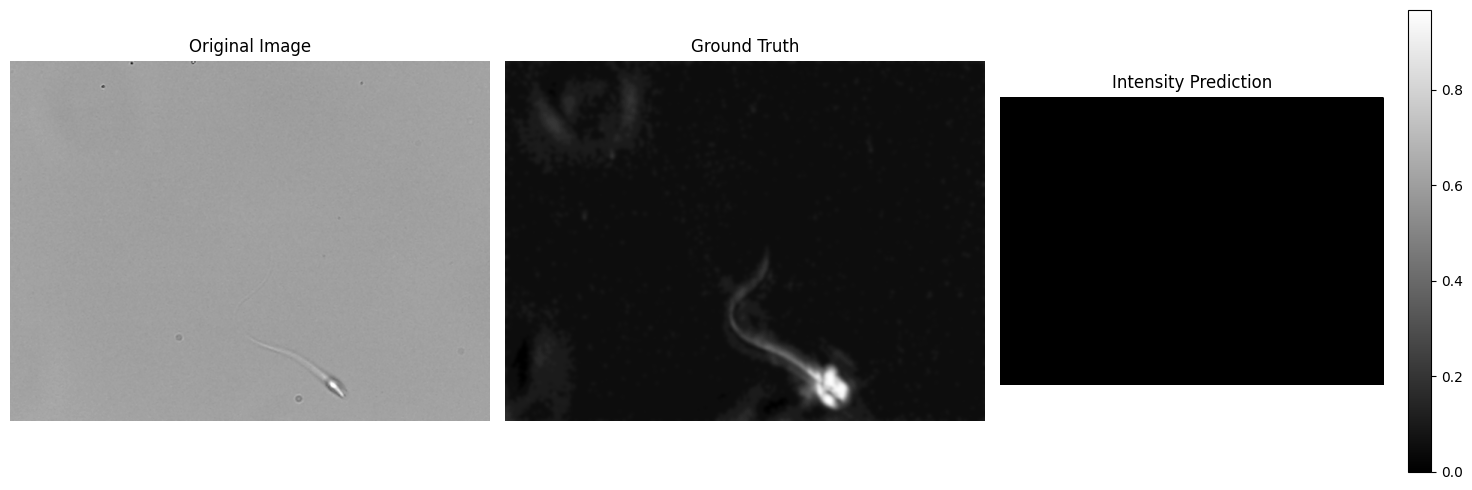

In [20]:

# Load your single image
source_img = io.imread(os.path.join(bright_path, image_name[20]))/255
target_img = io.imread(os.path.join(value_path, image_name[20]))
if len(source_img.shape) == 2:
    source_img = source_img[..., np.newaxis]


# Create a batch
batch_x = np.array([source_img], dtype=np.float32)
batch_y = np.array([target_img], dtype=np.float32)


# Preprocess the input image and ground truth mask


# Generate prediction
prediction = unet_model.predict(batch_y)

# Expand dimensions for prediction

# Plot the images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Original Image
axs[0].imshow(batch_x[0], cmap="gray")
axs[0].set_title("Original Image")
#plt.colorbar(plt.cm.ScalarMappable(cmap="gray"), ax=axs[0], orientation='vertical')
axs[0].axis("off")

# Ground Truth
axs[1].imshow(batch_y[0], cmap="gray")
axs[1].set_title("Ground Truth")

#plt.colorbar(plt.cm.ScalarMappable(cmap="gray"), ax=axs[1], orientation='vertical')

axs[1].axis("off")

# Prediction
#print(prediction[0])
pred=prediction[0][5]=0
im3= axs[2].imshow(prediction[0], cmap="gray")
axs[2].set_title("Intensity Prediction")
#plt.colorbar(plt.cm.ScalarMappable(cmap="gray"), ax=axs[2], orientation='vertical')
axs[2].axis("off")
fig.colorbar(im3, ax=axs[2])
#print(prediction[0])

plt.tight_layout()
plt.show()
import numpy as np
#from skimage.metrics import mean_squared_error, structural_similarity as ssim

# Assuming batch_y and prediction are properly scaled and have the correct dimensions



In [11]:
np.max(prediction[0])

0.0

In [12]:
# Optionally, save the metrics DataFrame to a CSV file
metrics_df.to_csv('training_metrics.csv', index=False)
metrics_df

NameError: name 'metrics_df' is not defined